In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.constants import R_earth
from astropy.coordinates import SkyCoord, Distance, get_sun
from astropy.time import Time, TimeDelta
from pandoravisibility import Visibility, analyze_yearly_visibility, plot_yearly_visibility, plot_visibility_summary

from astropy.visualization import time_support

from commissioningscheduler.roll import calculate_roll

In [3]:
# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Set max column width to None to prevent truncation of long cell content
pd.set_option('display.max_colwidth', None)

Downlinks reserved for Jan 18, 2026:

PANDORA	Svalbard Station	SG127	2026-01-18T16:29:20Z	2026-01-18T16:38:00Z	520	N/A	-1

PANDORA	Troll Station	TR21	2026-01-18T17:26:50Z	2026-01-18T17:34:50Z	480	N/A	-1

PANDORA	Svalbard Station	SG127	2026-01-18T18:07:20Z	2026-01-18T18:14:20Z	420	N/A	-1

PANDORA	Troll Station	TR21	2026-01-18T19:02:40Z	2026-01-18T19:11:20Z	520	N/A	-1

PANDORA	Troll Station	TR20	2026-01-18T20:38:30Z	2026-01-18T20:46:30Z	480	N/A	-1

PANDORA	Troll Station	TR21	2026-01-18T22:14:10Z	2026-01-18T22:21:10Z	420	N/A	-1

PANDORA	Troll Station	TR21	2026-01-18T23:49:00Z	2026-01-18T23:56:00Z	420	N/A	-1

MST is UTC-7, so for 12-4pm MST, we want 19:00:00 - 23:00:00 UTC, with at least one calendar between 20:00:00 - 21:00:00 UTC

In [4]:
line1 = "1 99152U 80229J   26017.75114583  .00000000  00000-0  37770-3 0    07"
line2 = "2 99152  97.8003  18.8171 0003829 259.1072 192.9926 14.87777498    09"

In [5]:
vis = Visibility(line1, line2)

In [6]:
# Define start and stop times
tstart = Time("2026-01-18T19:00:00.000")
tstop = Time("2026-01-18T23:00:00.000")  # Example stop time

# Calculate times with a step of 1 minute
deltas = np.arange(0, (tstop - tstart).to_value(u.min), 1) * u.min
times = tstart + TimeDelta(deltas)

# Use these times with your Visibility module
state = vis.get_state(times)

Let's try a primary target first.

In [7]:
# TOI-942 from Gaia DR3:
target_coord = SkyCoord(
    ra=76.6496195413261 * u.deg,
    dec=-20.245613095254143 * u.deg,
    pm_ra_cosdec=15.435349387243585 * u.mas / u.year,
    pm_dec=-3.9563373306798844 * u.mas / u.year,
    obstime=Time.strptime("2016", "%Y"),
    distance=Distance(parallax=6.6028586079112195 * u.mas, allow_negative=True),
    radial_velocity=23.413946 * u.km / u.s,
).apply_space_motion(Time.now())

# calculate the visibilities of the target at our specified times
targ_vis = vis.get_visibility(target_coord, times)

print(target_coord.ra.degree)
print(target_coord.dec.degree)

76.64966546848733
-20.24562413985104


Now an occultation target.

In [8]:
# GJ_3470 from Gaia DR3:
occ_coord = SkyCoord(
    ra=119.77347532185624 * u.deg,
    dec=15.391201153609417 * u.deg,
    pm_ra_cosdec=-185.7063619241512 * u.mas / u.year,
    pm_dec=-56.99404074674391 * u.mas / u.year,
    obstime=Time.strptime("2016", "%Y"),
    distance=Distance(parallax=34.01722474122476 * u.mas, allow_negative=True),
    radial_velocity=25.945986 * u.km / u.s,
).apply_space_motion(Time.now())

# calculate the visibilities of the target at our specified times
occ_vis = vis.get_visibility(occ_coord, times)

print(occ_coord.ra.degree)
print(occ_coord.dec.degree)

119.77293761990153
15.39104204827022


In [9]:
print(len(times))
print(len(targ_vis))

241
241


In [10]:
df = pd.DataFrame({'time': times, 'targ_vis': targ_vis, 'occ_vis': occ_vis})

In [11]:
print(df)

                        time  targ_vis  occ_vis
0    2026-01-18T19:00:00.000      True    False
1    2026-01-18T19:01:00.000      True    False
2    2026-01-18T19:02:00.000      True    False
3    2026-01-18T19:03:00.000      True    False
4    2026-01-18T19:04:00.000      True    False
5    2026-01-18T19:05:00.000      True    False
6    2026-01-18T19:06:00.000      True    False
7    2026-01-18T19:07:00.000      True    False
8    2026-01-18T19:08:00.000      True    False
9    2026-01-18T19:09:00.000      True    False
10   2026-01-18T19:10:00.000      True    False
11   2026-01-18T19:11:00.000      True    False
12   2026-01-18T19:12:00.000      True    False
13   2026-01-18T19:13:00.000      True    False
14   2026-01-18T19:14:00.000      True    False
15   2026-01-18T19:15:00.000      True    False
16   2026-01-18T19:16:00.000      True    False
17   2026-01-18T19:17:00.000      True    False
18   2026-01-18T19:18:00.000      True    False
19   2026-01-18T19:19:00.000      True  

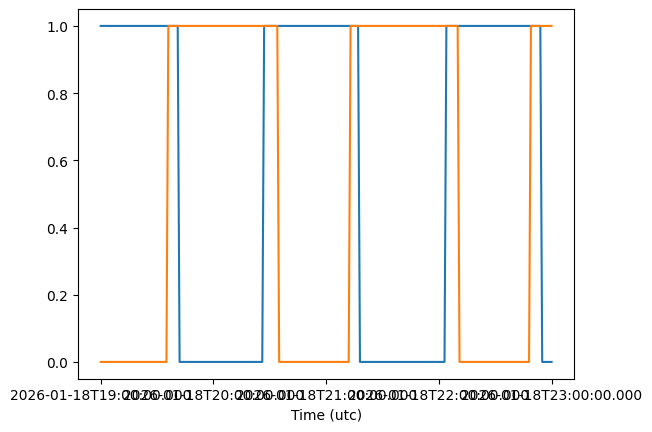

In [12]:
with time_support():
    plt.plot(times, targ_vis)
    plt.plot(times, occ_vis)
    plt.show();

In [13]:
str(uuid.uuid4())

'b404cbfd-dec7-431a-b44e-4778ae20e7d4'

In [14]:
calculate_roll(
    ra=119.77293770450642,
    dec=15.391042073304819,
    obs_time=Time('2026-01-18T21:16:00Z', format='isot', scale='utc')
)

np.float64(351.9610221306576)